In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE as smote
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as PCA

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv("HTRU_2.csv")

# Istraživanje podataka nad bazom o pulsarima

## Šta su pulsari
#### Tip neutronske zvezde koja na svojim polovima konstantno ispaljuje jake zrake elektromagnetnog(radio) zračenja
#### Pošto se rotiraju, iz naše perspektive to zračenje vidimo kao periodično pulsiranje radio talasa, odatle i naziv puls + r
#### Moramo, pošto su oni jako daleko, uzeti u obzir dve stvari:
-  pozadinsko zračenje iz svemira koje pravi šum
-  prelamanje i razliku u brzini različitih delova spektra zraka, koje proizvodi kašnjenje

#### Problem sa pozadinskim zračenjem prevazilazimo tako što pretpostavimo period, snimamo signal neko vreme i onda ga preklopimo po periou:

<div>
<img src="pulsestack-e1552071632736.gif" width="300"/>
</div>

#### Pošto je pozadinsko zračenje nasumično ono se poništi a zrak pulsara, ukoliko smo pogodili po kom periodu da ga preklopimo, se pojača

#### Problem sa prelamanjem, tj disperzijom se rešava tako što se pri merenju uzmu razdaljine i brzine u obzir i koreguje se oblik krive, ali u tom procesu se unosi odredjena dosa nesigurnosti pa moramo uvesti još jednu krivu: mera disperzije razmere signala i šuma (eng. dispersion measure tignal to noise ratio, skr. DM-SNR curve)

<div>
<img src="dispersion.png" width="300"/>
</div>

<div>
<img src="pulsar_features.png" width="800"/>
</div>

#### Obe krive opisujemo koristeći četiri numeričke vrednosti:
-  Srednja vrednost (aritmetička sredina)
-  Standardna devijacija (prosečno odstupanje elementa od srednje vrednosti)
-  Kurtoza (špicastost talasa)
-  Iskrivljenost (asimetrična iskrivljenost talasa)

In [3]:
data.columns = ['Mean IP', 'Standard deviation IP', 'Excess kurtosis IP', 'Skewness IP',
                'Mean DS', 'Standard deviation DS', 'Excess kurtosis DS', 'Skewness DS',
                'Class']

#### Nazive atributa pisemo skraceno:
-  ip - Integrated Profile - raspodela frekvencija merenog signala
-  ds - Dispersion Measure-Signal to Noise Rratio curve - raspodela razmera signala i šuma po meri disperzije

In [4]:
data.shape

(17897, 9)

#### imamo sedamnaest hiljada instanci i devet atributa

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mean IP                17897 non-null  float64
 1   Standard deviation IP  17897 non-null  float64
 2   Excess kurtosis IP     17897 non-null  float64
 3   Skewness IP            17897 non-null  float64
 4   Mean DS                17897 non-null  float64
 5   Standard deviation DS  17897 non-null  float64
 6   Excess kurtosis DS     17897 non-null  float64
 7   Skewness DS            17897 non-null  float64
 8   Class                  17897 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


#### od tih devet atributa jedan je klasni koj moze imati vrednost 0 - instanca nije pulsar ili 1 - instanca jeste pulsar
#### ostalih osam su neprekidni podaci zapisani u pokretnom zarezu koji opisuju po 4 osobine dveju gorenavedenih krivih:

In [6]:
data.describe()

,Mean IP,Standard deviation IP,Excess kurtosis IP,Skewness IP,Mean DS,Standard deviation DS,Excess kurtosis DS,Skewness DS,Class
count,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.00000
mean,111.078321,46.549021,0.477897,1.770417,12.614926,26.326918,8.303574,104.859419,0.09158
std,25.652705,6.843040,1.064056,6.168058,29.473637,19.471042,4.506217,106.517270,0.28844
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.00000
25%,100.929688,42.375426,0.027108,-0.188528,1.923077,14.437330,5.781485,34.957119,0.00000
50%,115.078125,46.946435,0.223241,0.198736,2.801839,18.459977,8.433872,83.068996,0.00000
75%,127.085938,51.022887,0.473349,0.928206,5.464883,28.428152,10.702973,139.310905,0.00000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.00000


#### prosek klasnog atributa je oko 0.09 sto znaci da na svakih 100 instanci imamo samo 9 pulsara, treba uzeti u obzir dakle da su klase nebalansirane

In [7]:
dataPositive = data[data['Class'] == 1]
dataNegative = data[data['Class'] == 0]

<IPython.core.display.Javascript object>


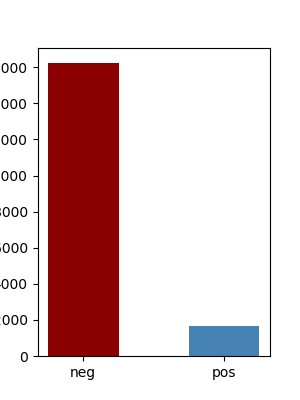

In [8]:
plt.figure(figsize = (3, 4))
plt.bar(['neg','pos'],[dataNegative.shape[0], dataPositive.shape[0]], width = 0.5, color = ['DarkRed', 'SteelBlue'])
plt.show()

In [9]:
data.isna().sum()



Mean IP                  0
Standard deviation IP    0
Excess kurtosis IP       0
Skewness IP              0
Mean DS                  0
Standard deviation DS    0
Excess kurtosis DS       0
Skewness DS              0
Class                    0
dtype: int64

#### nema nedostajucih vrednosti

In [10]:
brojNula = {}
for key in data.keys():
    brojNula[key] = (data[key] == 0).sum()
    
brojNula

{'Mean IP': 0,
 'Standard deviation IP': 0,
 'Excess kurtosis IP': 0,
 'Skewness IP': 0,
 'Mean DS': 0,
 'Standard deviation DS': 0,
 'Excess kurtosis DS': 0,
 'Skewness DS': 0,
 'Class': 16258}

#### nema sumnjivih vrednosti, mozemo verovati podacima da su svi uneti

In [11]:
correlation = data.corr()
correlation

,Mean IP,Standard deviation IP,Excess kurtosis IP,Skewness IP,Mean DS,Standard deviation DS,Excess kurtosis DS,Skewness DS,Class
Mean IP,1.000000,0.547099,-0.873899,-0.738780,-0.298832,-0.307005,0.234345,0.144057,-0.673187
Standard deviation IP,0.547099,1.000000,-0.521418,-0.539792,0.006893,-0.047606,0.029436,0.027714,-0.363704
Excess kurtosis IP,-0.873899,-0.521418,1.000000,0.945730,0.414362,0.432873,-0.341216,-0.214505,0.791592
Skewness IP,-0.738780,-0.539792,0.945730,1.000000,0.412052,0.415135,-0.328846,-0.204790,0.709526
Mean DS,-0.298832,0.006893,0.414362,0.412052,1.000000,0.796554,-0.615974,-0.354276,0.400873
Standard deviation DS,-0.307005,-0.047606,0.432873,0.415135,0.796554,1.000000,-0.809791,-0.575809,0.491532
Excess kurtosis DS,0.234345,0.029436,-0.341216,-0.328846,-0.615974,-0.809791,1.000000,0.923744,-0.390819
Skewness DS,0.144057,0.027714,-0.214505,-0.204790,-0.354276,-0.575809,0.923744,1.000000,-0.259123
Class,-0.673187,-0.363704,0.791592,0.709526,0.400873,0.491532,-0.390819,-0.259123,1.000000


#### matrica korelacije:

<IPython.core.display.Javascript object>


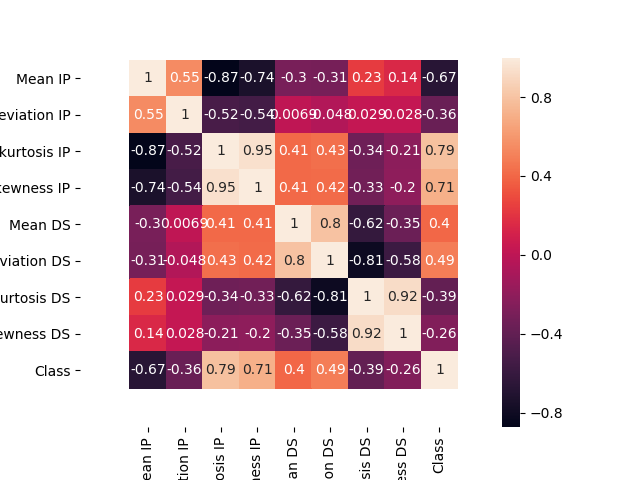

In [14]:
fig, ax = plt.subplots()
sb.heatmap(correlation, annot=True)
plt.show()

#### gustina raspodele instanci po pojedinacnim atributima:

<IPython.core.display.Javascript object>


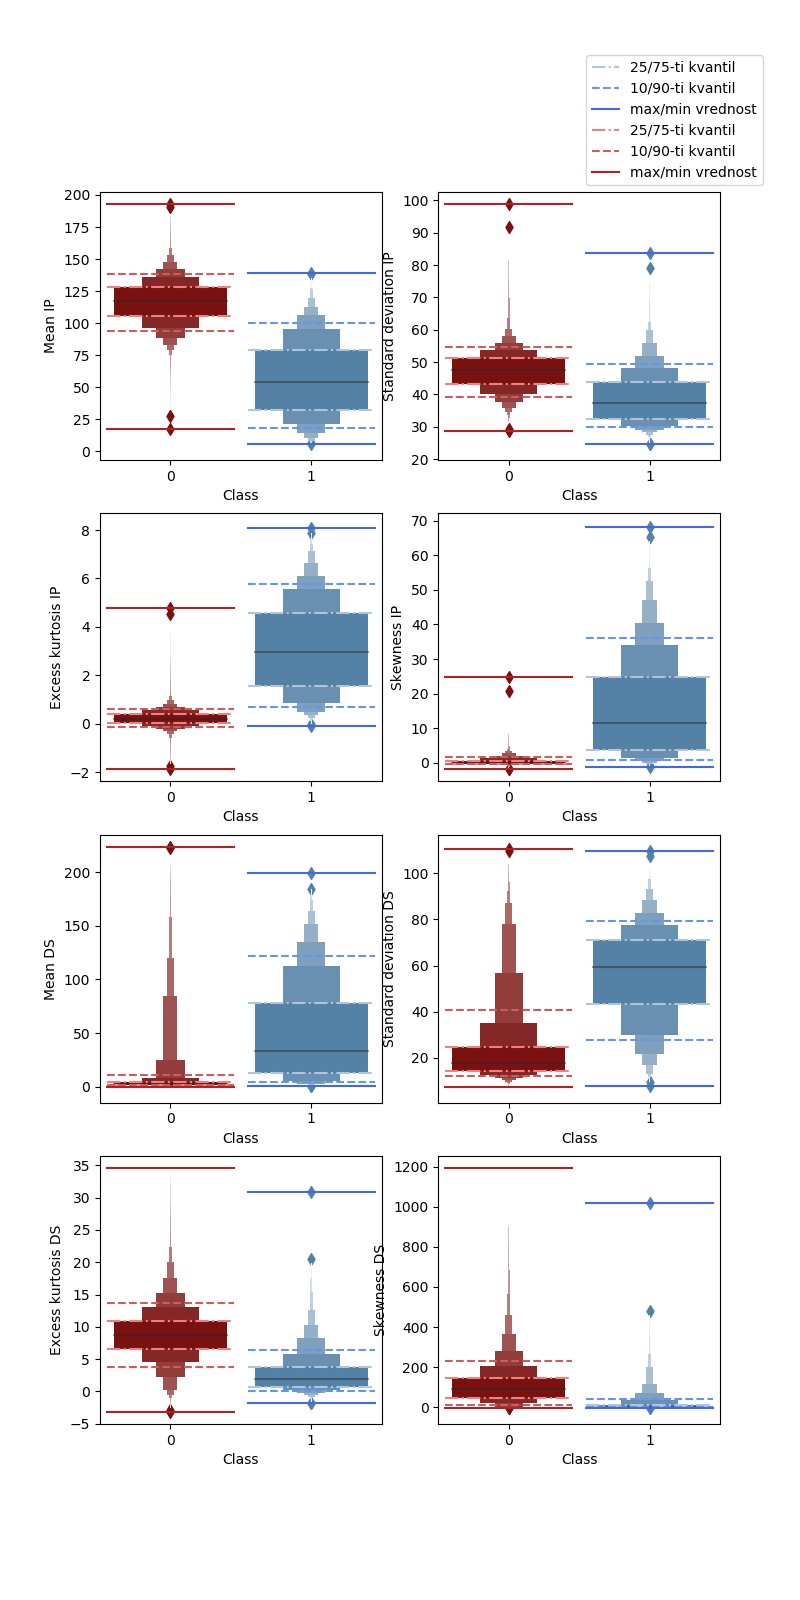

In [15]:
i = 1
plt.figure(figsize = (8, 16))
for key in data.keys():
    if key != 'Class':
        plt.subplot(4, 2, i)
        sb.boxenplot(x = data['Class'], y = data[key], palette = ['DarkRed', 'SteelBlue'], k_depth = 'trustworthy')
        plt.axhline(dataPositive[key].quantile(q = 0.75), xmin = 0.525, xmax = 0.975, color = 'LightSteelBlue', linestyle = '-.', label = '25/75-ti kvantil')
        plt.axhline(dataPositive[key].quantile(q = 0.25), xmin = 0.525, xmax = 0.975, color = 'LightSteelBlue', linestyle = '-.')
        plt.axhline(dataPositive[key].quantile(q = 0.90), xmin = 0.525, xmax = 0.975, color = 'CornFlowerBlue', linestyle = '--', label = '10/90-ti kvantil')
        plt.axhline(dataPositive[key].quantile(q = 0.10), xmin = 0.525, xmax = 0.975, color = 'CornFlowerBlue', linestyle = '--')
        plt.axhline(dataPositive[key].max(), xmin = 0.525, xmax = 0.975, color = 'RoyalBlue', label = 'max/min vrednost')
        plt.axhline(dataPositive[key].min(), xmin = 0.525, xmax = 0.975, color = 'RoyalBlue')
        plt.axhline(dataNegative[key].quantile(q = 0.75), xmin = 0.025, xmax=0.475, color = 'LightCoral', linestyle = '-.', label = '25/75-ti kvantil')
        plt.axhline(dataNegative[key].quantile(q = 0.25), xmin = 0.025, xmax=0.475, color = 'LightCoral', linestyle = '-.')
        plt.axhline(dataNegative[key].quantile(q = 0.90), xmin = 0.025, xmax=0.475, color = 'IndianRed', linestyle = '--', label = '10/90-ti kvantil')
        plt.axhline(dataNegative[key].quantile(q = 0.10), xmin = 0.025, xmax=0.475, color = 'IndianRed', linestyle = '--')
        plt.axhline(dataNegative[key].max(), xmin = 0.025, xmax = 0.475, color = 'FireBrick', label = 'max/min vrednost')
        plt.axhline(dataNegative[key].min(), xmin = 0.025, xmax = 0.475, color = 'FireBrick')
        if i == 2:
            plt.legend(bbox_to_anchor = (0.5, 1))
        i = i + 1
plt.show()

#### grafik instanci po svim parova atributa

<IPython.core.display.Javascript object>


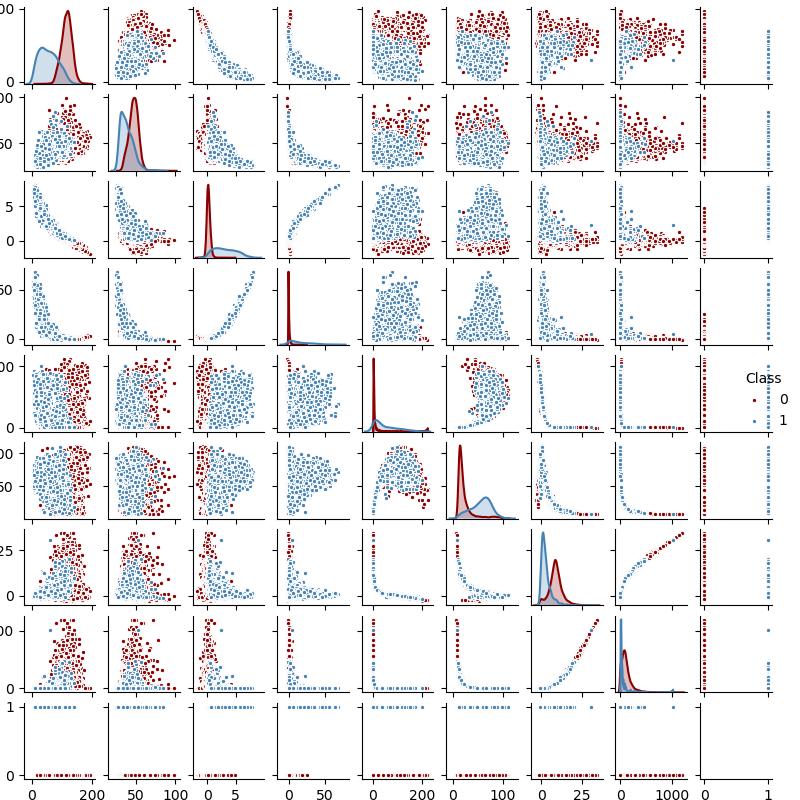

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


In [16]:
perplot = sb.pairplot(data, hue = 'Class', palette = ['DarkRed', 'SteelBlue'], plot_kws = {"s":10}, )
perplot.fig.set_size_inches(8,8)

#### sledi standardizacija podataka radi analize glavnih komponenti i prikazivanja u trodimenzionom prostoru

In [17]:
sc = StandardScaler()
xs = data.drop(['Class'], axis = 'columns')
x_ss = sc.fit_transform(xs)
ys = data['Class']

In [18]:
pca = PCA()
x_pca = pca.fit_transform(x_ss)

<IPython.core.display.Javascript object>


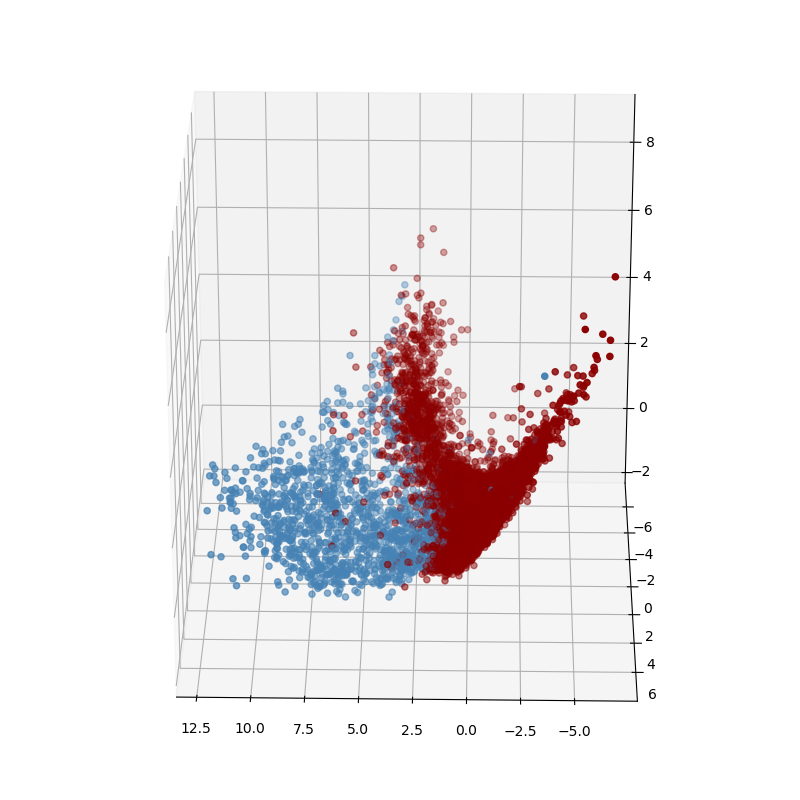

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [19]:
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.animation as anim

fig = plt.figure(figsize = (8, 8))
ax = Axes3D(fig)
fig.add_axes(ax)

ax.view_init(27,91)

def boja(xs):
    ret = []
    for x in xs:
        if x == 1:
            ret.append('SteelBlue')
        else:
            ret.append('DarkRed')
    return ret

sc = ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c = boja(ys))

### pošto smo istražili kako nam podaci izgledaju možemo preći na pravljenje modela